In [1]:
import numpy as np
import matplotlib.pyplot as plt
from src.cyc_gbm import CycGBM
from src.cyc_gbm.utils import tune_kappa
from sklearn.model_selection import KFold
from scipy.optimize import minimize
from src.cyc_gbm.distributions import MultivariateNormalDistribution, initiate_distribution

In [2]:
rng = np.random.default_rng(seed=10)
n = 1000
p = 9
X = np.concatenate([np.ones((1, n)), rng.normal(0, 1, (p - 1, n))]).T
z0 = (
    1.5 * X[:, 1]
    + 2 * X[:, 3]
    - 0.65 * X[:, 2] ** 2
    + 0.5 * np.abs(X[:, 3]) * np.sin(0.5 * X[:, 2])
    + 0.45 * X[:, 4] * X[:, 5] ** 2
)
z1 = 1 + 0.02 * X[:, 2] + 0.5 * X[:, 1] * (X[:, 1] < 2) + 1.8 * (X[:, 5] > 0)
z2 = 1.2 * X[:, 3] + 0.3 * X[:, 2]
z = np.stack([z0, z1, z2])
distribution = initiate_distribution(dist="multivariate_normal")
y = distribution.simulate(z=z, random_state=5)

In [3]:
# Set hyperparameters
kappa_max = 1000
max_depth = 1
min_samples_leaf = 2
eps = [0.5,0.25,0.1]
n_splits = 4
random_state = 5

tuning_results = tune_kappa(
    X=X,
    y=y,
    kappa_max=kappa_max,
    eps=eps,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
    dist="multivariate_normal",
    n_splits=n_splits,
    random_state=random_state,
)

kappa_opt = tuning_results["kappa"]
print(f"Optimal kappa: {kappa_opt}")

Optimal kappa: [20 20 21]


BOpt 0: 20
BOpt 1: 16
BOpt 2: 10


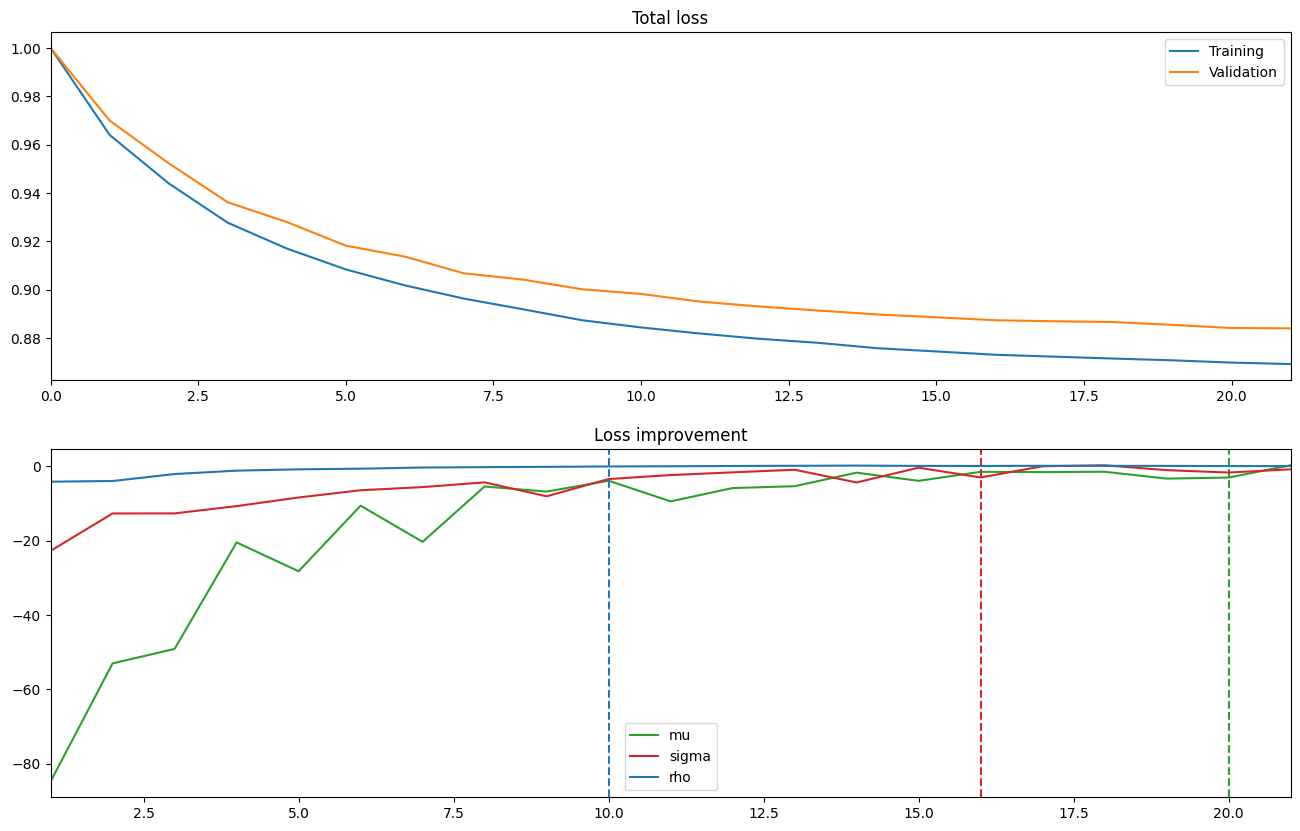

In [14]:
# Set hyperparameters
BMax = kappa_max
nFolds = n_splits
d = 3
epsilon = eps

# Loss function
def lossEval(z, y):
    return distribution.loss(z=z, y=y)


# Gradients
def grad0(z, y):
    return distribution.grad(z=z, y=y, j=0)


def grad1(z, y):
    return distribution.grad(z=z, y=y, j=1)

def grad2(z, y):
    return distribution.grad(z=z, y=y, j=2)


# Gradient list
grads = [grad0, grad1, grad2]

kf = KFold(n_splits=nFolds, shuffle=True, random_state=random_state)

# Tree fitting
from sklearn.tree import DecisionTreeRegressor as regressionTree


def trainTree(z, y, x, grad, max_depth, min_samples_leaf):
    tree = regressionTree(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    g = grad(z, y)
    tree.fit(x, -g)
    return tree


# Local tree training function
def trainThisTree(
    z, y, x, grad, max_depth=max_depth, min_samples_leaf=min_samples_leaf
):
    return trainTree(z, y, x, grad, max_depth, min_samples_leaf)


# Evaluation arrays (indexed by fold, boosting step)
lossTrain, lossValid = np.zeros((nFolds, BMax, d)), np.zeros((nFolds, BMax, d))

# Dimension indicator for score adding
e = [np.stack([[0]] * j + [[1]] + [[0]] * (d - j - 1)) for j in range(0, d)]

# Intercept model
xTrain, yTrain = X, y
nTrain = len(yTrain)

toMin = lambda z: lossEval(z, yTrain).sum()
zOpt = minimize(toMin, np.zeros(d))["x"]

# Fit to all folds
for i, idx in enumerate(kf.split(X)):
    # Training and validation data
    idx_train, idx_valid = idx
    xTrain, yTrain = X[idx_train], y[idx_train]
    xValid, yValid = X[idx_valid], y[idx_valid]
    nTrain, nValid = len(yTrain), len(yValid)

    # Initiate score
    zTrain = zOpt.repeat(nTrain).reshape((d, nTrain))
    zValid = zOpt.repeat(nValid).reshape((d, nValid))

    # Initiate loss
    for j in range(0, d):
        lossTrain[i, 0, j] = lossEval(zTrain, yTrain).sum()
        lossValid[i, 0, j] = lossEval(zValid, yValid).sum()

    # Build trees
    for b in range(1, BMax):
        # For all parameter dimensions
        for j in range(0, d):
            # Fit a tree
            tree = trainThisTree(zTrain, yTrain, xTrain, grads[j])

            # Score updates
            zTrainPlus = tree.predict(xTrain)
            zValidPlus = tree.predict(xValid)

            # Look at all unique node values
            nodeValues = np.unique(zTrainPlus)
            for k, nodeValue in enumerate(nodeValues):
                # Indices with this node value
                indicesTrain = zTrainPlus == nodeValue
                indicesValid = zValidPlus == nodeValue
                # Optimize step size
                gammaOpt = minimize(
                    lambda gamma: lossEval(
                        zTrain[:, indicesTrain] + e[0] * gamma, yTrain[indicesTrain]
                    ).sum(),
                    jac=lambda gamma: (
                        grad0(
                            zTrain[:, indicesTrain] + e[0] * gamma, yTrain[indicesTrain]
                        )
                    ).sum(),
                    x0=nodeValue,
                )["x"][0]
                # Manipulate node values
                zTrainPlus[indicesTrain] = gammaOpt
                zValidPlus[indicesValid] = gammaOpt

            # Update score
            zTrain[j] += epsilon[j] * zTrainPlus
            zValid[j] += epsilon[j] * zValidPlus

            # Update loss
            lossTrain[i, b, j] = lossEval(zTrain, yTrain).sum()
            lossValid[i, b, j] = lossEval(zValid, yValid).sum()

        # Check breaking criteria
        if (
            lossValid[i, b, 0] > lossValid[i, b - 1, 1]
            and lossValid[i, b, 1] > lossValid[i, b, 0]
        ):
            lossTrain[i, b + 1 :, :] = lossTrain[i, b, -1]
            lossValid[i, b + 1 :, :] = lossValid[i, b, -1]
            break

# Sum the losses
lossTrainTot = lossTrain.sum(axis=0)[:, -1]
lossValidTot = lossValid.sum(axis=0)[:, -1]

# Calculate loss improvements
lossValidPerUpdate = lossValid.sum(axis=0)
lossImprovement = np.zeros((BMax, d))
lossImprovement[1:, 0] = lossValidPerUpdate[1:, 0] - lossValidPerUpdate[:-1, 1]
lossImprovement[1:, 1] = lossValidPerUpdate[1:, 1] - lossValidPerUpdate[1:, 0]
lossImprovement[1:, 2] = lossValidPerUpdate[1:, 2] - lossValidPerUpdate[1:, 1]

# Pick optimal number of boosters
BOpts = np.argmax(lossImprovement[1:] > 0, axis=0)
BOpt = int(max(BOpts))
[print(f"BOpt {j}: {int(BOpts[j])}") for j in range(0, d)]

# Visualize
fig, axs = plt.subplots(2, 1, figsize=(16, 16 / 1.61))

# Show validation losses
axs[0].plot(lossTrainTot[: BOpt + 2] / np.abs(lossTrainTot[0]), label="Training")
axs[0].plot(lossValidTot[: BOpt + 2] / np.abs(lossValidTot[0]), label="Validation")
axs[0].legend()
axs[0].set_title("Total loss")
axs[0].set_xlim([0, BOpt + 1])

param_names = {0: 'mu',
               1: 'sigma',
               2: 'rho'}

# Show loss improvements
colors = ["tab:green", "tab:red", "tab:blue"]
for j in range(0, d):
    axs[1].plot(
        np.arange(1, BOpt + 3),
        lossImprovement[1 : BOpt + 3, j],
        label=param_names[j],
        color=colors[j],
    )
    axs[1].axvline(BOpts[j], linestyle="--", color=colors[j])

axs[1].legend()
axs[1].set_title("Loss improvement")
axs[1].set_xlim([1, BOpt + 1]);

BOpt 0: 20
BOpt 1: 16
BOpt 2: 10


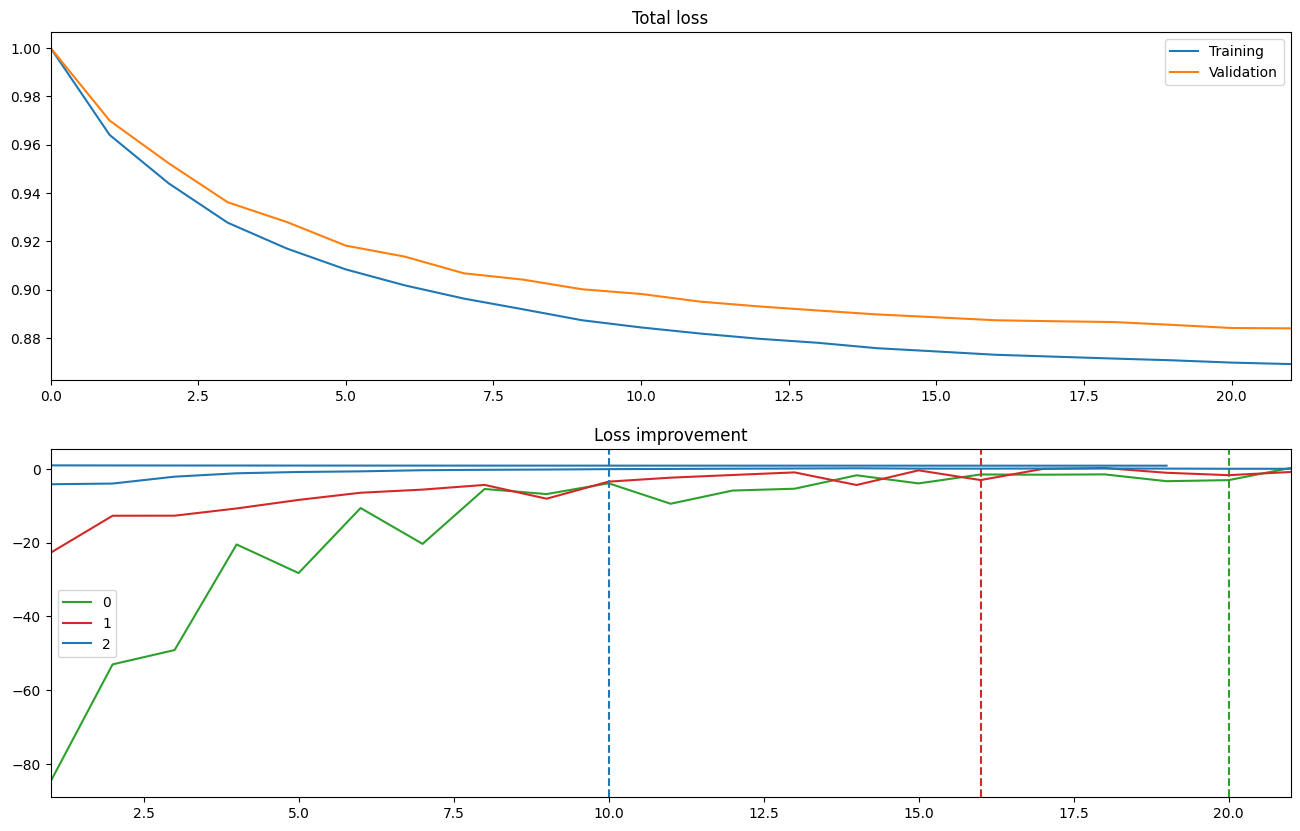

In [15]:
[print(f"BOpt {j}: {int(BOpts[j])}") for j in range(0, d)]

# Visualize
fig, axs = plt.subplots(2, 1, figsize=(16, 16 / 1.61))

# Show validation losses
axs[0].plot(lossTrainTot[: BOpt + 2] / np.abs(lossTrainTot[0]), label="Training")
axs[0].plot(lossValidTot[: BOpt + 2] / np.abs(lossValidTot[0]), label="Validation")
axs[0].legend()
axs[0].set_title("Total loss")
axs[0].set_xlim([0, BOpt + 1])

# Show loss improvements
for j in range(0, d):
    axs[1].plot(
        np.arange(1, BOpt + 3),
        lossImprovement[1 : BOpt + 3, j],
        label=j,
        color=colors[j],
    )
    axs[1].axvline(BOpts[j], linestyle="--", color=colors[j])

axs[1].legend()
axs[1].set_title("Loss improvement")
axs[1].set_xlim([1, BOpt + 1])
plt.plot(lossValidTot[:20] / lossValidTot[0])

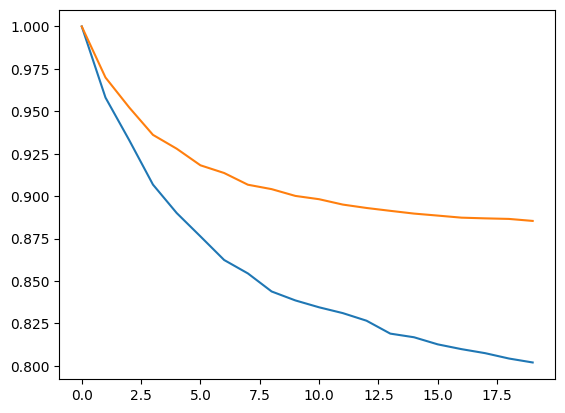

In [17]:
loss_total = tuning_results['loss'].sum(axis=0)[:, -1]
plt.plot(loss_total[:20] / loss_total[0])
plt.plot(lossValidTot[:20] / lossValidTot[0])
